In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

import scipy.stats as stats

In [2]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 
from sklearn.preprocessing import PowerTransformer

In [3]:
df = pd.read_csv("concrete_data.csv")

In [4]:
df.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              1030 non-null   float64
 1   Blast Furnace Slag  1030 non-null   float64
 2   Fly Ash             1030 non-null   float64
 3   Water               1030 non-null   float64
 4   Superplasticizer    1030 non-null   float64
 5   Coarse Aggregate    1030 non-null   float64
 6   Fine Aggregate      1030 non-null   float64
 7   Age                 1030 non-null   int64  
 8   Strength            1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


In [6]:
df.shape

(1030, 9)

In [7]:
X = df.drop(columns = ["Strength"] )
y = df["Strength"]

In [8]:
X_train , X_test , y_train , y_test = train_test_split(X,y , test_size=0.2 , random_state=42)

In [9]:
# Applying linear Regression without any transformation 

lr = LinearRegression()

lr.fit(X_train , y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [10]:
y_pred = lr.predict(X_test)

In [35]:
r2_score(y_test , y_pred)

0.6275531792314848

In [36]:
# cross validation 
lr = LinearRegression()
np.mean(cross_val_score(lr, X,y, scoring='r2'))

0.4609940491662864

- Features likely have:
  - Skewness
  - Non-constant variance
- Linear Regression is not seeing a stable linear relationship across folds
- This is a **strong signal** that preprocessing can help

In [16]:
## ploting the histogram + kde and qq plot of each column without transformation 

sns.set_style("whitegrid")

def plot_distribution_and_qq(df,cols):
    for col in cols:
        data = df[col].dropna()

        fig,axes = plt.subplots(1,2 , figsize=(14,4))
        sns.histplot(data , kde=True , ax= axes[0] , bins=30 )
        axes[0].set_title(f"{col} Distribution (Histogram + KDE)")
        axes[0].set_xlabel(col)

        ## Q-Q plot
        stats.probplot(data, dist="norm" , plot=axes[1])
        axes[1].set_title(f"{col} Q-Q Plot")

        plt.tight_layout()
        plt.show()
          
        

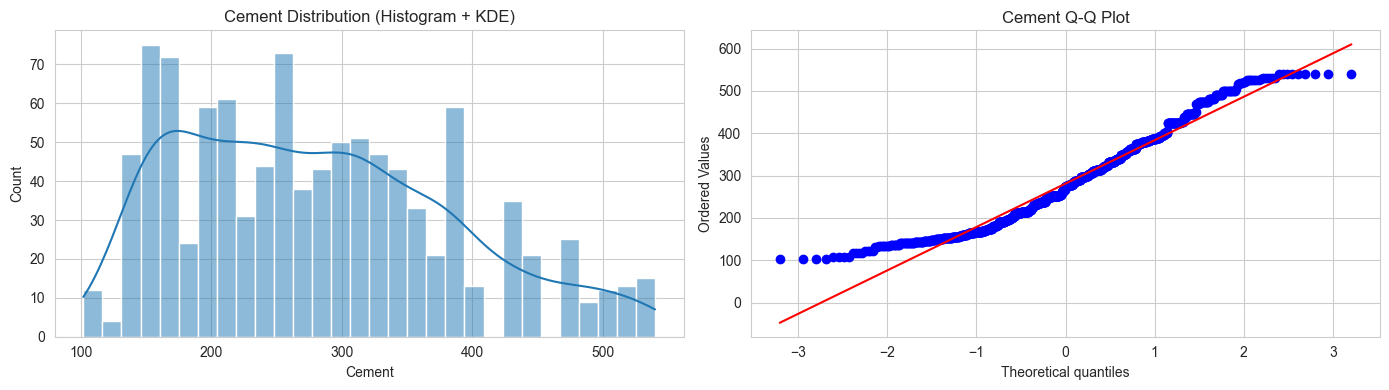

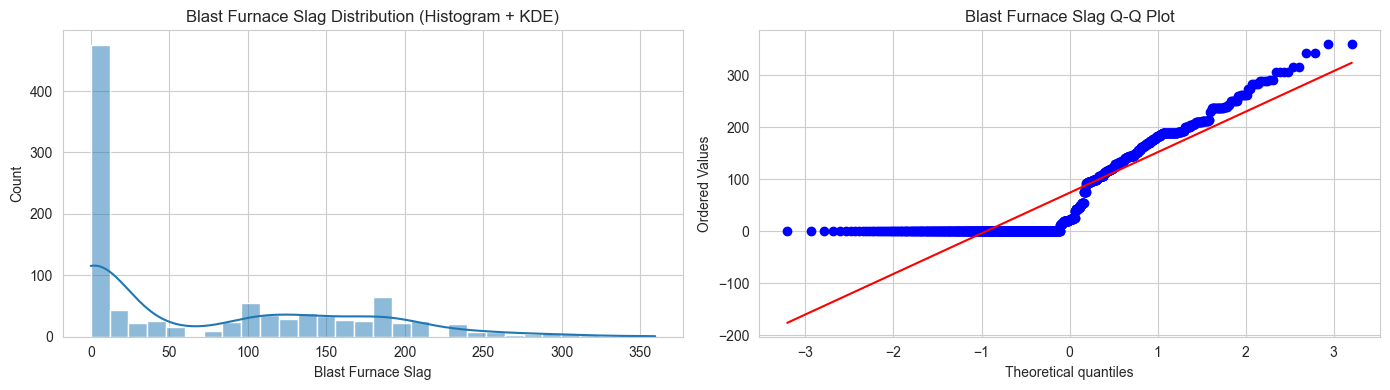

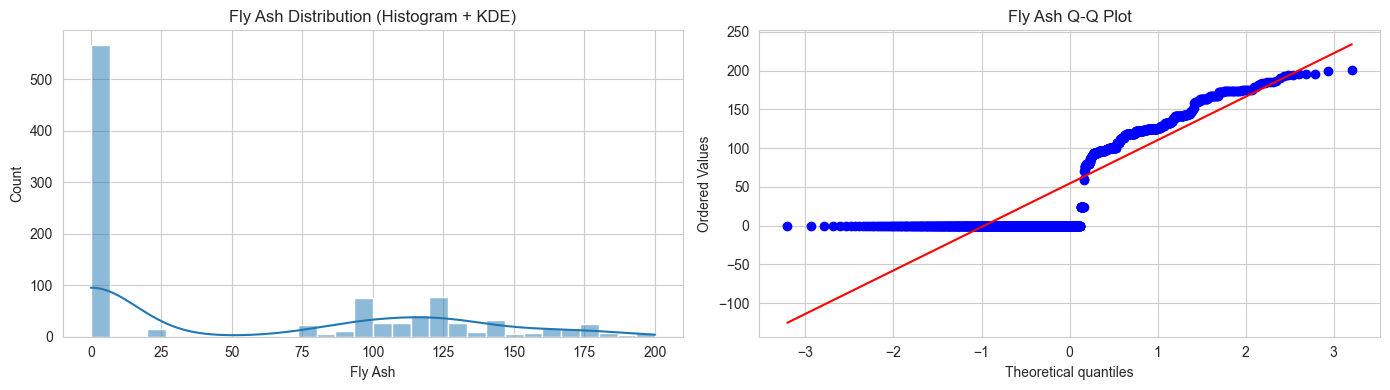

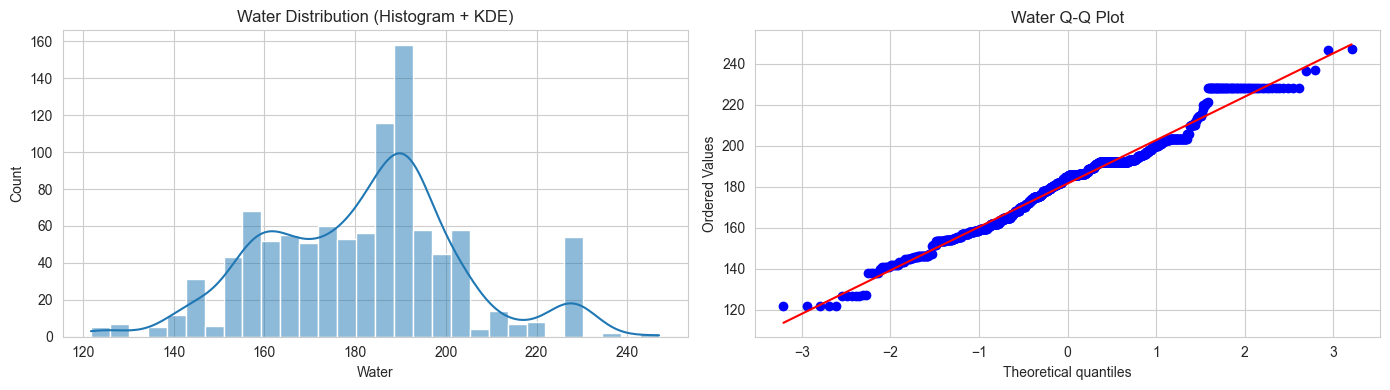

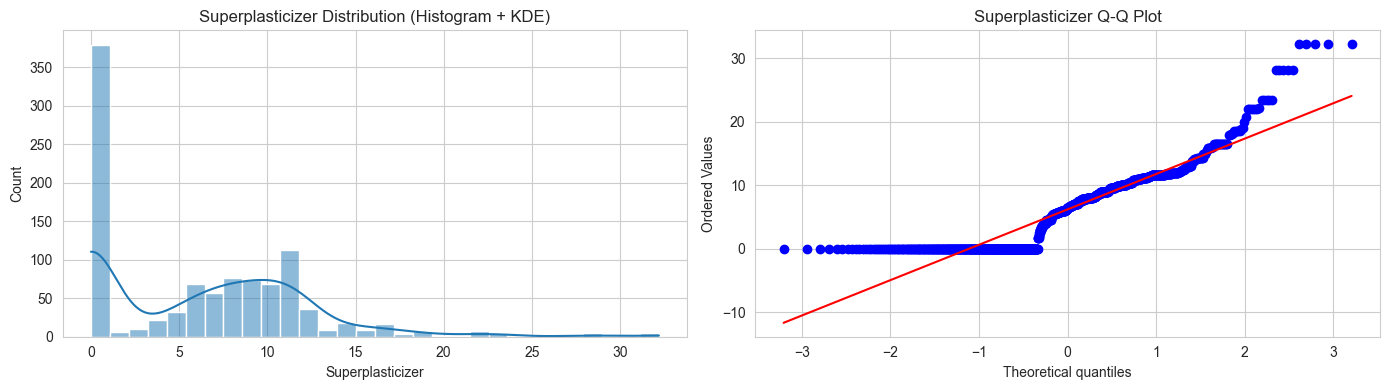

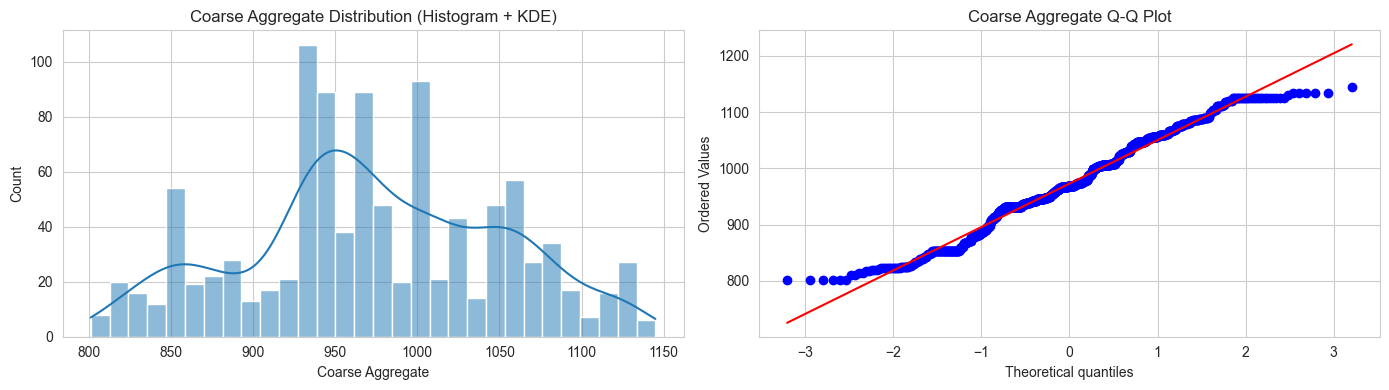

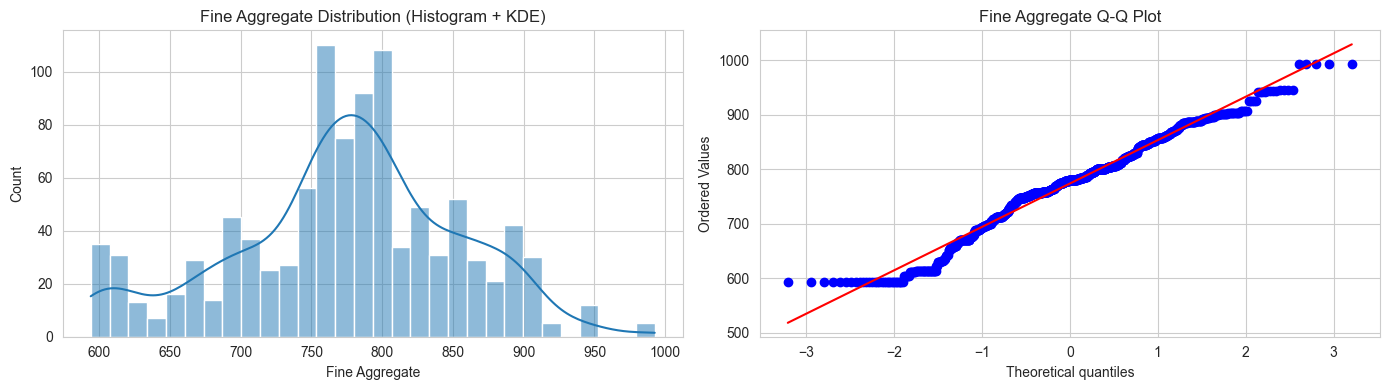

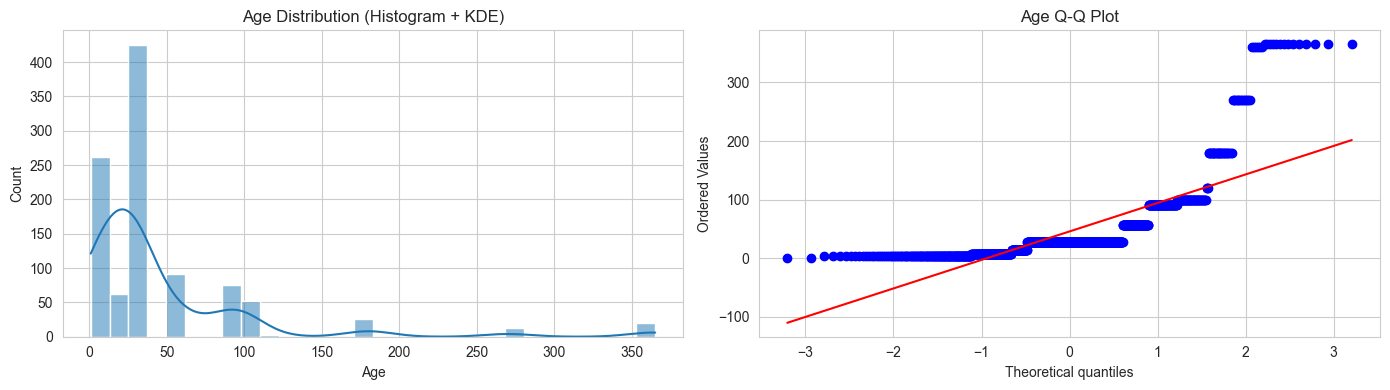

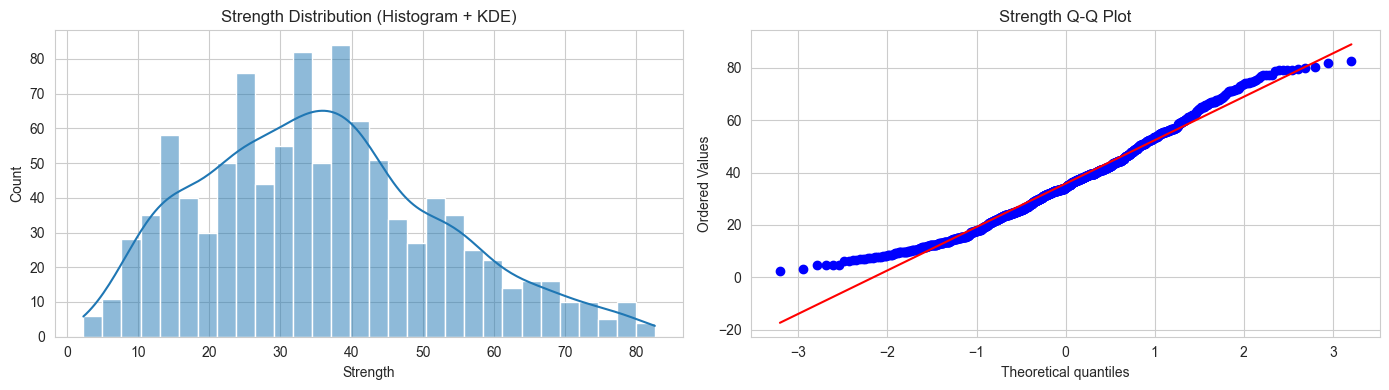

In [18]:
numeric_cols = df.columns  
plot_distribution_and_qq(df, numeric_cols)

In [21]:
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols].head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [20]:
## applying Box-Cox tranform

In [23]:
pt  = PowerTransformer(method ="box-cox")

X_train_transformed = pt.fit_transform(X_train + 0.00000001)
X_test_transformed = pt.transform(X_test+ 0.00000001)

pd.DataFrame({"cols": X_train.columns , "box_cox_lambdas" : pt.lambdas_})

,cols,box_cox_lambdas
0,Cement,0.177025
1,Blast Furnace Slag,0.020795
2,Fly Ash,-0.031170
3,Water,0.772681
4,Superplasticizer,0.077874
5,Coarse Aggregate,1.129813
6,Fine Aggregate,1.782018
7,Age,0.066631


In [27]:
lr2 = LinearRegression()
lr2.fit(X_train_transformed , y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [29]:
y_pred2 = lr2.predict(X_test_transformed)

In [37]:
r2_score(y_test , y_pred2)

0.8038297994931106

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

pipe = Pipeline([
    ("power", PowerTransformer(method="box-cox")),
    ("model", LinearRegression())
])

np.mean(cross_val_score(pipe, X + 1e-8, y, scoring="r2", cv=5))

0.658134660721211

In [43]:
## before and after comparison of qq plot
def plot_qq_before_after(X_before, X_after, columns):
    for i, col in enumerate(columns):
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Before transformation
        stats.probplot(
            X_before[col].dropna(),
            dist="norm",
            plot=axes[0]
        )
        axes[0].set_title(f"{col} — Before Transformation")

        # After transformation
        stats.probplot(
            X_after[:, i],
            dist="norm",
            plot=axes[1]
        )
        axes[1].set_title(f"{col} — After Transformation")

        plt.tight_layout()
        plt.show()

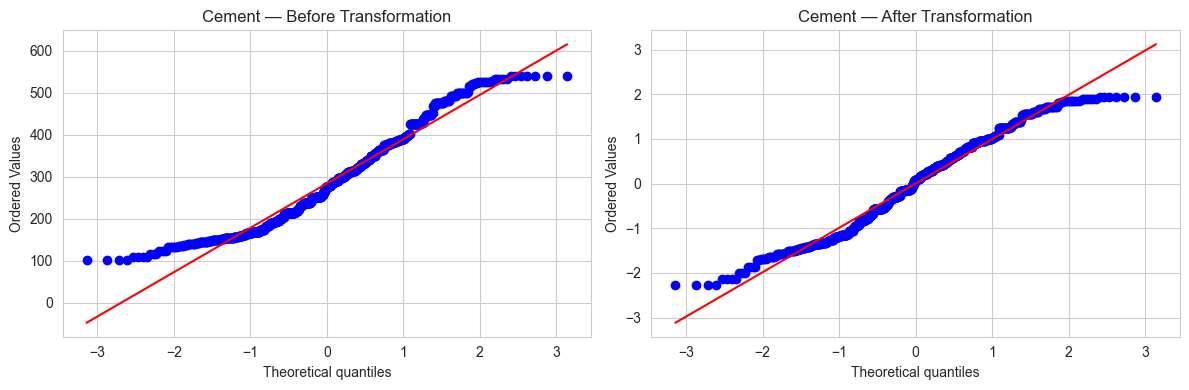

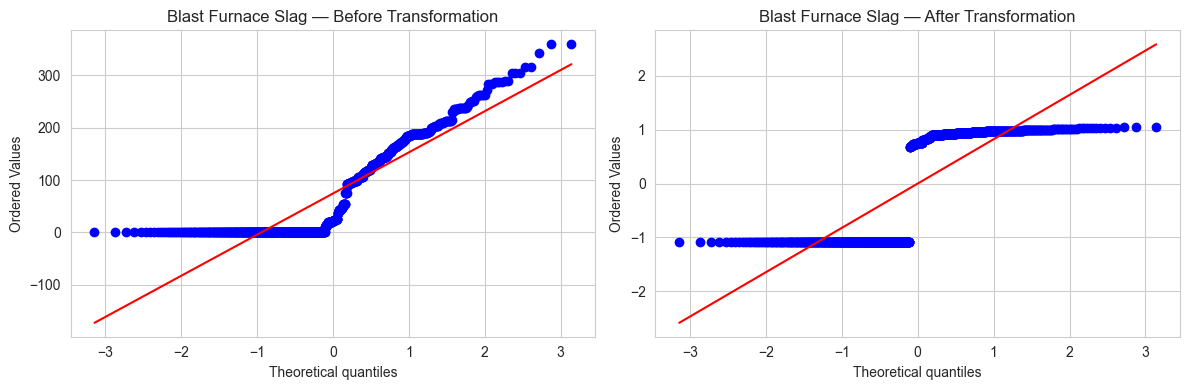

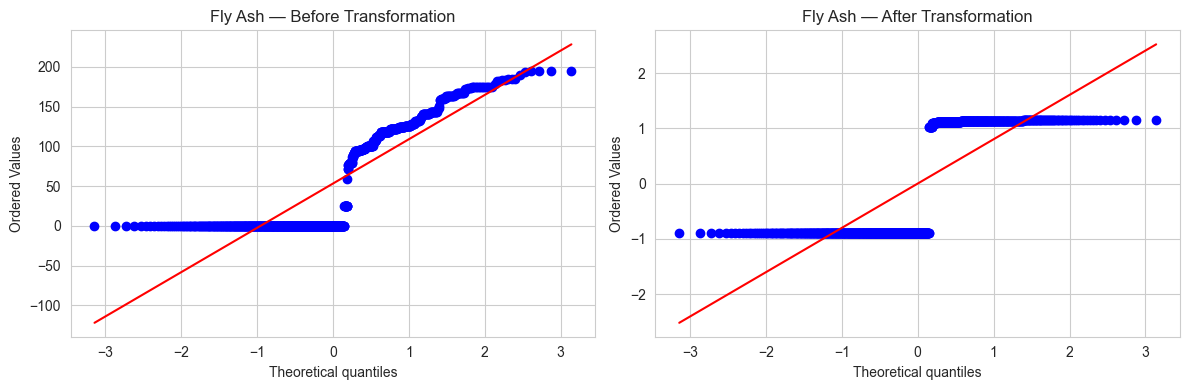

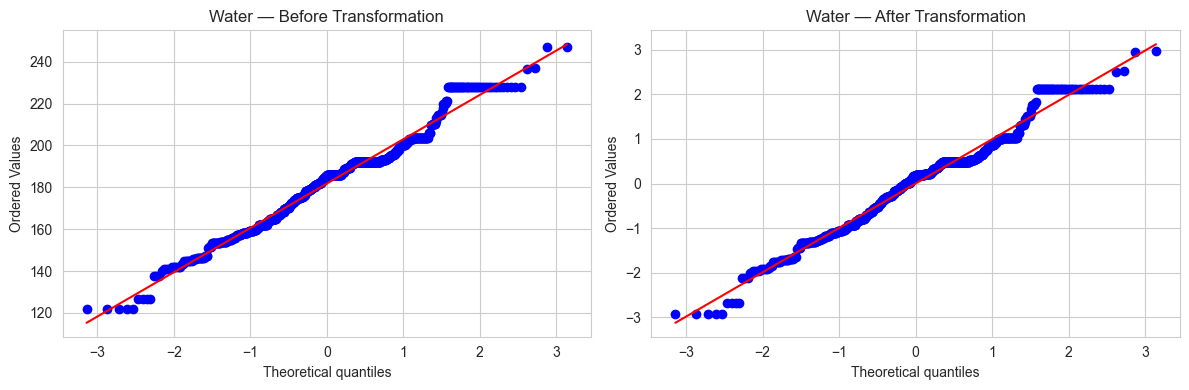

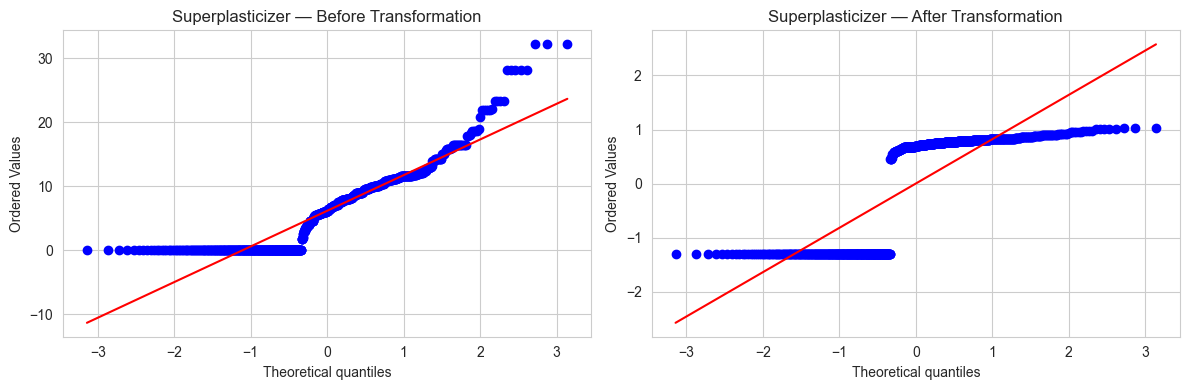

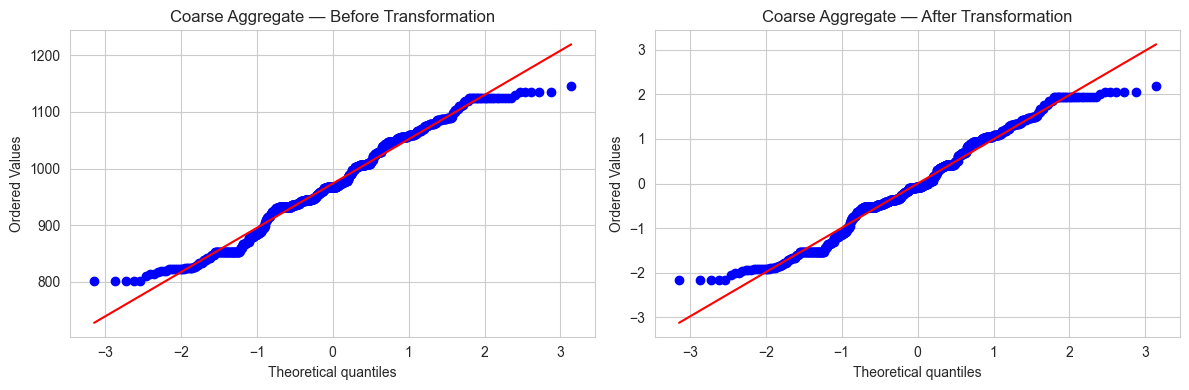

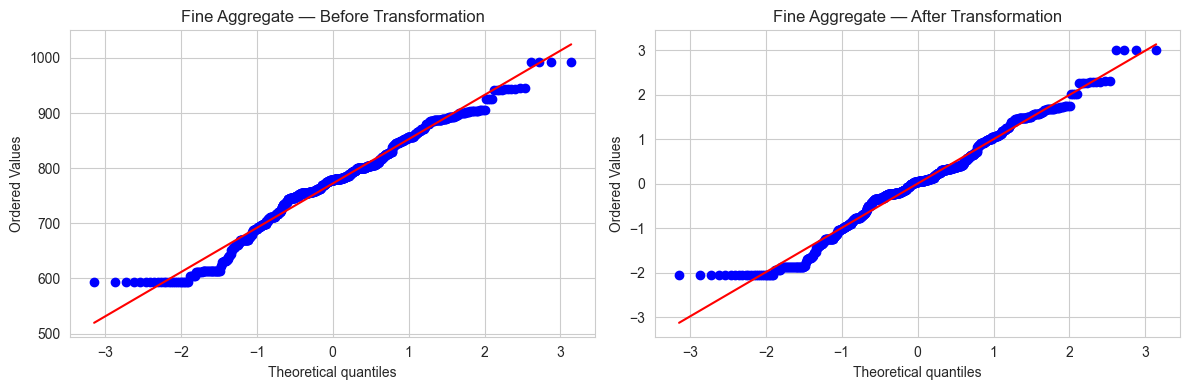

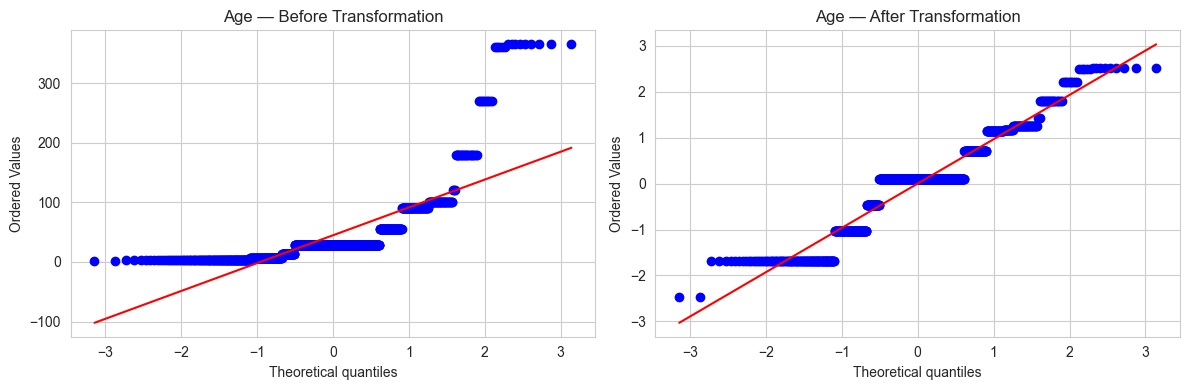

In [44]:
plot_qq_before_after(
    X_before=X_train,
    X_after=X_train_transformed,
    columns=X_train.columns
)

In [45]:
## lets apply the yeo - johnson 

In [46]:
pt_yeo = PowerTransformer(method="yeo-johnson")

X_train_yeo = pt_yeo.fit_transform(X_train)
X_test_yeo  = pt_yeo.transform(X_test)

In [47]:
pd.DataFrame({
    "column": X_train.columns,
    "yeo_johnson_lambda": pt_yeo.lambdas_
})

,column,yeo_johnson_lambda
0,Cement,0.174348
1,Blast Furnace Slag,0.015715
2,Fly Ash,-0.161447
3,Water,0.771307
4,Superplasticizer,0.253935
5,Coarse Aggregate,1.130050
6,Fine Aggregate,1.783100
7,Age,0.019885


In [48]:
def plot_qq_before_after(X_before, X_after, columns):
    for i, col in enumerate(columns):
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Before transformation
        stats.probplot(
            X_before[col].dropna(),
            dist="norm",
            plot=axes[0]
        )
        axes[0].set_title(f"{col} — Before Transformation")

        # After Yeo–Johnson
        stats.probplot(
            X_after[:, i],
            dist="norm",
            plot=axes[1]
        )
        axes[1].set_title(f"{col} — After Yeo–Johnson")

        plt.tight_layout()
        plt.show()

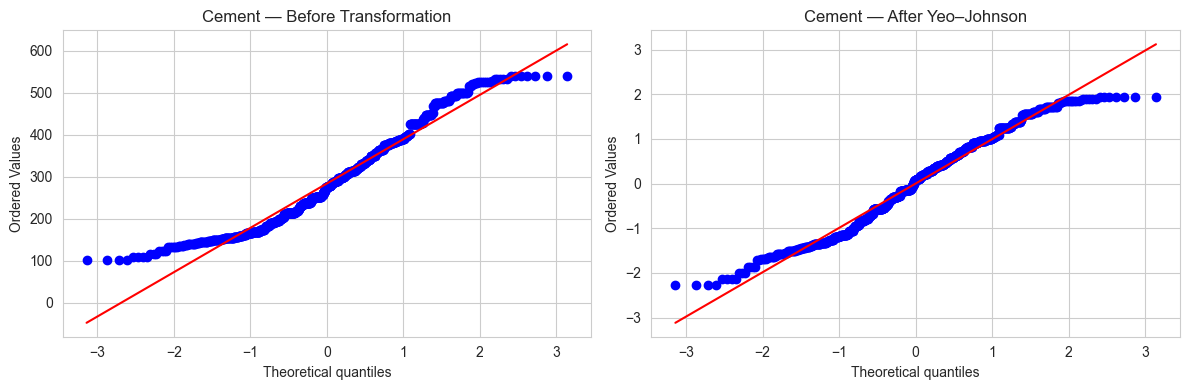

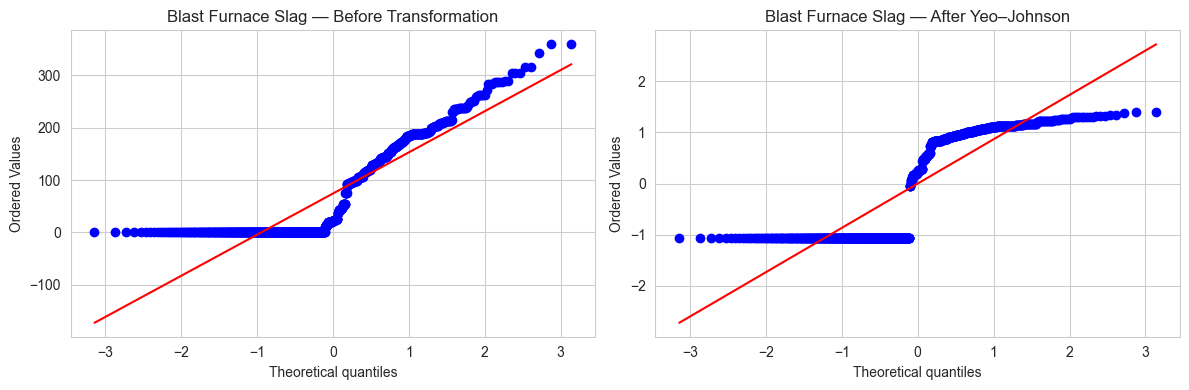

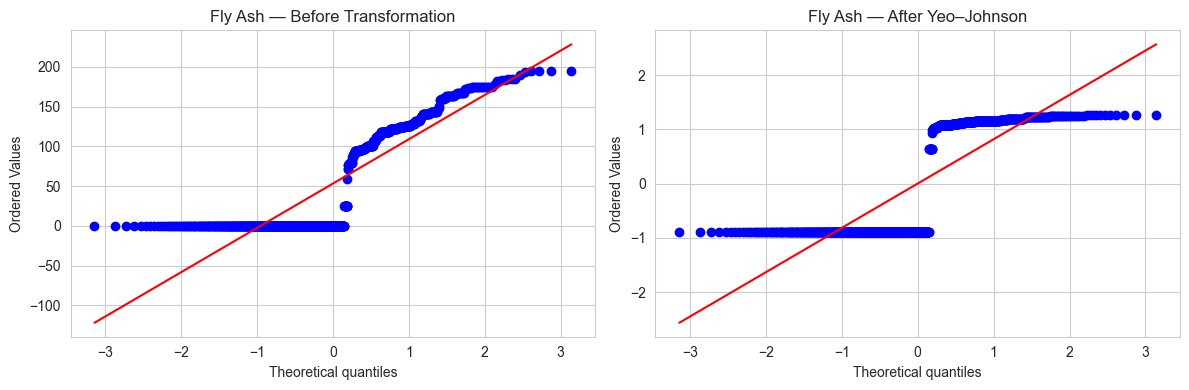

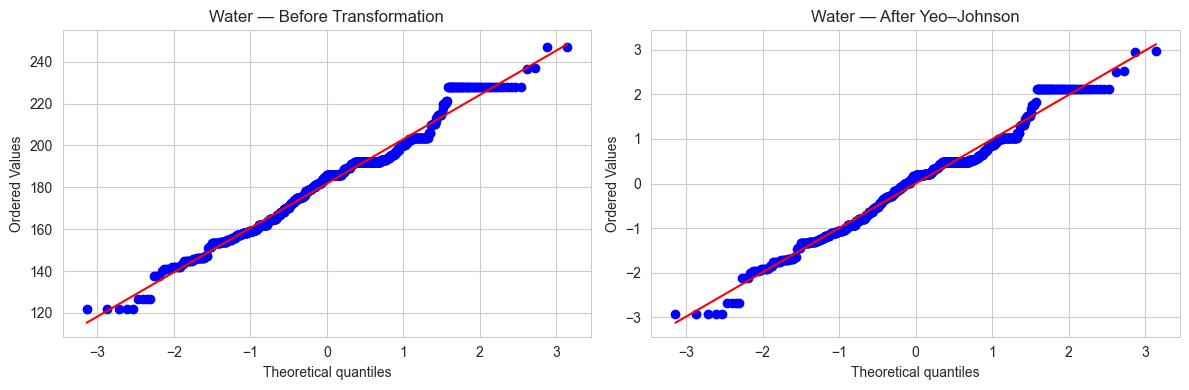

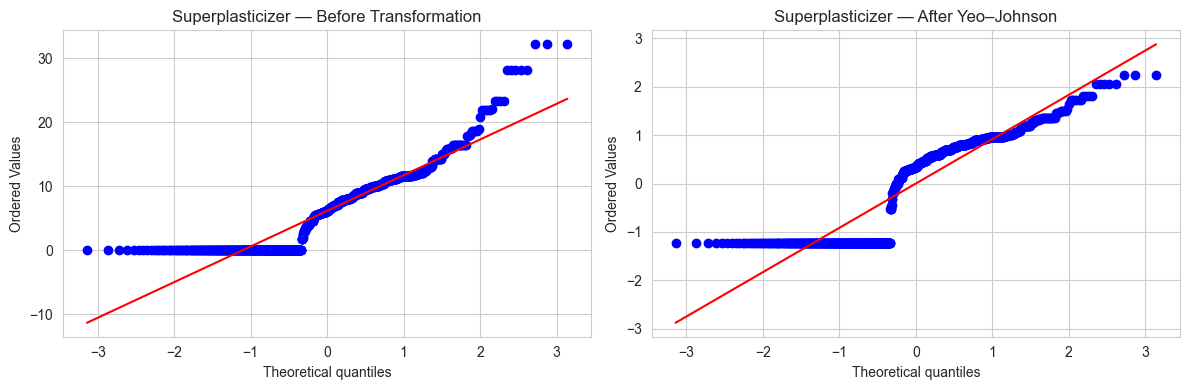

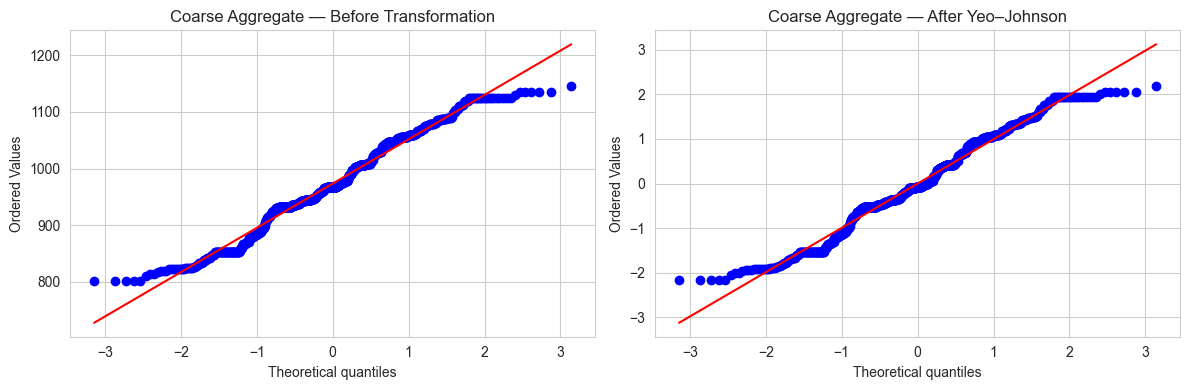

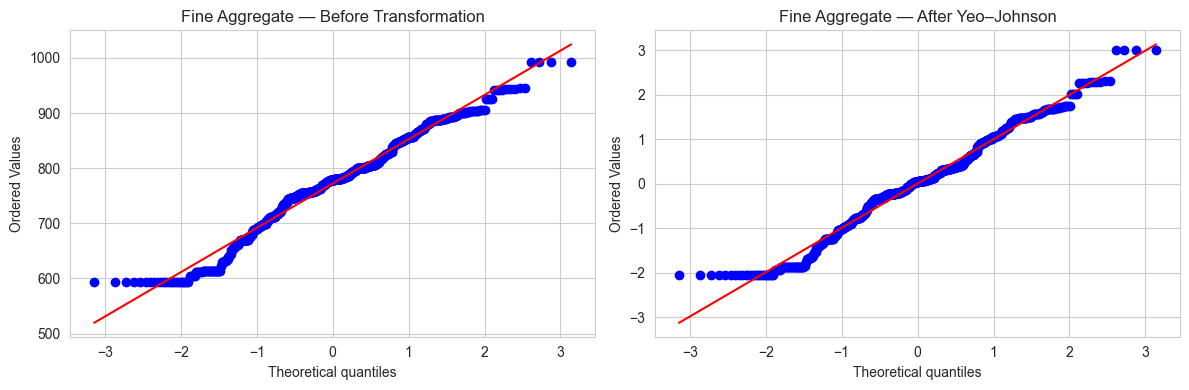

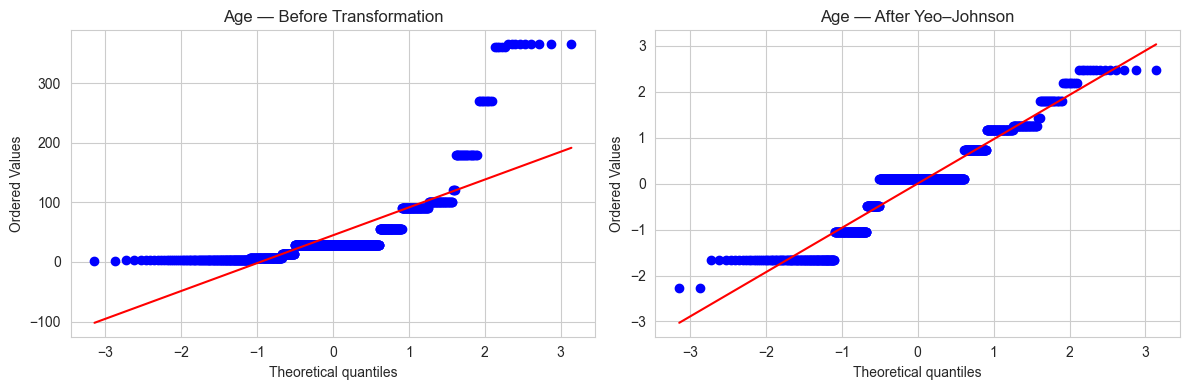

In [49]:
plot_qq_before_after(
    X_before=X_train,
    X_after=X_train_yeo,
    columns=X_train.columns
)

In [50]:
pipe_yeo = Pipeline([
    ("power" , PowerTransformer(method = "yeo-johnson")),
    ("model" , LinearRegression())
])

In [51]:
pipe_yeo.fit(X_train, y_train)

,steps,"[('power', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,method,'yeo-johnson'
,standardize,True
,copy,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [52]:
y_pred_yeo = pipe_yeo.predict(X_test)

In [54]:
r2_score(y_test , y_pred_yeo)

0.8161906513354853

In [57]:
cross_val_yeo = cross_val_score(pipe_yeo  , X ,y,scoring='r2' , cv=5)

print("CV R2 scores:" , cross_val_yeo )
print("Mean CV r2 : " , cross_val_yeo.mean())

CV R2 scores: [0.72595735 0.7029625  0.75812138 0.81591052 0.36530948]
Mean CV r2 :  0.6736522476585327


## Day 31 Learning Summary: Box–Cox & Yeo–Johnson Transformations

Today’s focus was on **power transformations** and how they improve model performance by making data more suitable for linear models.

---

### Key Concepts Learned

- **Power transformations** reduce skewness and stabilize variance.
- They help numeric features behave more like a normal distribution.
- This improves learning for **linear and distance-based models**.

---

### Box–Cox Transformation
- Requires **strictly positive values** (x > 0).
- Automatically learns the optimal power parameter (λ).
- Effective for heavily right-skewed, positive features.
- Sensitive to zeros and negatives.

---

### Yeo–Johnson Transformation
- Generalized version of Box–Cox.
- Works with **positive, zero, and negative values**.
- Does not require adding small constants.
- Safer and more flexible in real-world datasets.

---

### Practical Implementation Insights

- Always **fit transformations on training data only**.
- Use **Pipeline** to avoid data leakage, especially with cross-validation.
- Validate transformations visually using **Q–Q plots**.
- Quantify improvement using **R² and cross-validation scores**.

---

### What We Observed After Implementation

- Q–Q plots became straighter after power transformation.
- Variance and skewness were reduced.
- Cross-validated R² scores became more stable.
- Yeo–Johnson performed as well as or better than Box–Cox without extra constraints.

---

### Best Practices Learned

- Prefer **Yeo–Johnson by default**.
- Use Box–Cox only when data is strictly positive.
- Do not scale before analyzing distributions.
- Combine power transformation and modeling in a single pipeline.

---

### Key Takeaway

> **Power transformations like Box–Cox and Yeo–Johnson make linear models more reliable by correcting skewness in a data-driven way.**
